In [ ]:
# import necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

import warnings
warnings.filterwarnings('ignore') 

In [ ]:
# specify pathnames of directories and moseq_df/stats_df csvs generated by kpMoSeq

project_dir= '' # the full path to the project directory
model_name='' # name of model to analyze (e.g. something like `2023_05_23-15_19_03`)
fig_dir = '' # name of folder you want figures to be saved in
stats_dir = project_dir+model_name+'/stats/' # where you want stats files to be saved e.g. significant syllables, p-vals of pairwise comparisons
moseq_df_filename = 'moseq_df.csv' # csv filename of saved moseq_df
stats_df_filename = 'p_up_p_stats_df.csv' # csv filename of saved stats_df
sig_syllables_filename = 'p_up_p_sig_syllables_freq.csv' # csv filename of saved sig_syllables df, if saved -- if not, can generate below

moseq_df = pd.read_csv(project_dir+model_name+'/moseq_df/'+moseq_df_filename) # read in moseq_df
stats_df = pd.read_csv(project_dir+model_name+'/stats_df/'+stats_df_filename) # read in stats_df

In [ ]:
# define groups for comparison (group_1, group_2), statistic of interest (frequency or duration), and p-val
group_1 = 'f1_up'
group_2 = 'f1_p'
stat = 'frequency'
thresh = 0.05

In [ ]:
# define functions needed for analysis (from kpMoSeq code)

def run_kruskal(
    stats_df,
    statistic="frequency",
    n_perm=10000,
    seed=42,
    thresh=0.05,
    mc_method="fdr_bh",
):
    """Run Kruskal-Wallis test on syllable usage data.

    Parameters
    ----------
    stats_df : pandas.DataFrame
        DataFrame containing syllable usage data.
    statistic : str, optional
        Statistic to use for KW test, by default 'frequency'
    n_perm : int, optional
        Number of permutations to run, by default 10000
    seed : int, optional
        Random seed, by default 42
    thresh : float, optional
        Alpha threshold to consider syllable significant, by default 0.05
    mc_method : str, optional
        Multiple Corrections method to use, by default "fdr_bh"

    Returns
    -------
    df_k_real : pandas.DataFrame
        DataFrame containing KW test results.
    df_pval_corrected : pandas.DataFrame
        DataFrame containing Dunn's test results with corrected p-values.
    significant_syllables : list
        List of corrected KW significant syllables (syllables with p-values < thresh).
    """
    rnd = np.random.RandomState(seed=seed)
    # get grouped mean data
    grouped_data = (
        stats_df.pivot_table(
            index=["group", "name"], columns="syllable", values=statistic
        )
        .replace(np.nan, 0)
        .reset_index()
    )
    # compute KW constants
    vc = grouped_data.group.value_counts().loc[grouped_data.group.unique()]
    n_per_group = vc.values
    group_names = vc.index

    cum_group_idx = np.insert(np.cumsum(n_per_group), 0, 0)
    num_groups = len(group_names)

    # get all syllable usage data
    df_only_stats = grouped_data.drop(["group", "name"], axis=1)
    syllable_data = grouped_data.drop(["group", "name"], axis=1).values

    N_m, N_s = syllable_data.shape
    # Run KW and return H-stats
    h_all, real_ranks, X_ties = run_manual_KW_test(
        df_usage=df_only_stats,
        merged_usages_all=syllable_data,
        num_groups=num_groups,
        n_per_group=n_per_group,
        cum_group_idx=cum_group_idx,
        n_perm=n_perm,
        seed=seed,
    )

    # find the real k_real
    df_k_real = pd.DataFrame(
        [
            stats.kruskal(
                *np.array_split(syllable_data[:, s_i], np.cumsum(n_per_group[:-1]))
            )
            for s_i in range(N_s)
        ]
    )

    # multiple test correction
    df_k_real["p_adj"] = multipletests(
        ((h_all > df_k_real.statistic.values).sum(0) + 1) / n_perm,
        alpha=thresh,
        method=mc_method,
    )[1]

    # return significant syllables based on the threshold
    df_k_real["is_sig"] = df_k_real["p_adj"] <= thresh

    # Run Dunn's z-test statistics
    (
        null_zs_within_group,
        real_zs_within_group,
    ) = dunns_z_test_permute_within_group_pairs(
        grouped_data, vc, real_ranks, X_ties, N_m, group_names, rnd, n_perm
    )

    # Compute p-values from Dunn's z-score statistics
    df_pair_corrected_pvalues, _ = compute_pvalues_for_group_pairs(
        real_zs_within_group,
        null_zs_within_group,
        df_k_real,
        group_names,
        n_perm,
        thresh,
        mc_method,
    )

    # combine Dunn's test results into single DataFrame
    df_z = pd.DataFrame(real_zs_within_group)
    df_z.index = df_z.index.set_names("syllable")
    dunn_results_df = df_z.reset_index().melt(id_vars=[("syllable", "")])
    dunn_results_df.rename(
        columns={"variable_0": "group1", "variable_1": "group2"}, inplace=True
    )

    # Get intersecting significant syllables between
    intersect_sig_syllables = {}
    pvals = {}
    for pair in df_pair_corrected_pvalues.columns.tolist():
        intersect_sig_syllables[pair] = np.where(
            (df_pair_corrected_pvalues[pair] < thresh) & (df_k_real.is_sig)
        )[0]
        pvals[pair] = df_pair_corrected_pvalues[pair]

    return df_k_real, dunn_results_df, intersect_sig_syllables, pvals

def run_manual_KW_test(
    df_usage,
    merged_usages_all,
    num_groups,
    n_per_group,
    cum_group_idx,
    n_perm=10000,
    seed=42,
):
    """Run a manual Kruskal-Wallis test compare the results agree with the
    scipy.stats.kruskal function.

    Parameters
    ----------
    df_usage : pandas.DataFrame
        DataFrame with syllable usages. shape = (N_m, n_syllables)
    merged_usages_all : np.array
        numpy array format of the df_usage DataFrame.
    num_groups : int
        Number of unique groups
    n_per_group : list
        list of value counts for recordings per group. len == num_groups.
    cum_group_idx : list
        list of indices for different groups. len == num_groups + 1.
    n_perm : int, optional
        Number of permuted samples to generate, by default 10000
    seed : int, optional
        Random seed used to initialize the pseudo-random number generator, by default 42

    Returns
    -------
    h_all : np.array
        Array of H-stats computed for given n_syllables; shape = (n_perms, N_s)
    real_ranks : np.array
        Array of syllable ranks, shape = (N_m, n_syllables)
    X_ties : np.array
        1-D list of tied ranks, where if value > 0, then rank is tied. len(X_ties) = n_syllables
    """

    N_m, N_s = merged_usages_all.shape

    # create random index array n_perm times
    rnd = np.random.RandomState(seed=seed)
    perm = rnd.rand(n_perm, N_m).argsort(-1)

    # get degrees of freedom
    dof = num_groups - 1

    real_ranks = np.apply_along_axis(stats.rankdata, 0, merged_usages_all)
    X_ties = df_usage.apply(get_tie_correction, 0, N_m=N_m).values
    KW_tie_correct = np.apply_along_axis(stats.tiecorrect, 0, real_ranks)

    # rank data
    perm_ranks = real_ranks[perm]

    # get square of sums for each group
    ssbn = np.zeros((n_perm, N_s))
    for i in range(num_groups):
        ssbn += (
            perm_ranks[:, cum_group_idx[i] : cum_group_idx[i + 1]].sum(1) ** 2
            / n_per_group[i]
        )

    # h-statistic
    h_all = 12.0 / (N_m * (N_m + 1)) * ssbn - 3 * (N_m + 1)
    h_all /= KW_tie_correct
    p_vals = stats.chi2.sf(h_all, df=dof)

    # check that results agree
    p_i = np.random.randint(n_perm)
    s_i = np.random.randint(N_s)
    kr = stats.kruskal(
        *np.array_split(
            merged_usages_all[perm[p_i, :], s_i], np.cumsum(n_per_group[:-1])
        )
    )
    assert (kr.statistic == h_all[p_i, s_i]) & (
        kr.pvalue == p_vals[p_i, s_i]
    ), "manual KW is incorrect"

    return h_all, real_ranks, X_ties

def get_tie_correction(x, N_m):
    """Assign tied rank values to the average of the ranks they would have
    received if they had not been tied for Kruskal-Wallis helper function.

    Parameters
    ----------
    x : pd.Series
        syllable usages for a single recording.
    N_m : int
        Number of total recordings.

    Returns
    -------
    corrected_rank : float
        average of the inputted tied ranks.
    """

    vc = x.value_counts()
    tie_sum = 0
    if (vc > 1).any():
        tie_sum += np.sum(vc[vc != 1] ** 3 - vc[vc != 1])
    return tie_sum / (12.0 * (N_m - 1))

def dunns_z_test_permute_within_group_pairs(
    df_usage, vc, real_ranks, X_ties, N_m, group_names, rnd, n_perm
):
    """Run Dunn's z-test statistic on combinations of all group pairs, handling
    pre- computed tied ranks.

    Parameters
    ----------
    df_usage : pandas.DataFrame
        DataFrame containing only pre-computed syllable stats.
    vc : pd.Series
        value counts of recordings in each group.
    real_ranks : np.array
        Array of syllable ranks.
    X_ties : np.array
        1-D list of tied ranks, where if value > 0, then rank is tied
    N_m : int
        Number of recordings.
    group_names : pd.Index
        Index list of unique group names.
    rnd : np.random.RandomState
        Pseudo-random number generator.
    n_perm : int
        Number of permuted samples to generate.

    Returns
    -------
    null_zs_within_group : dict
        dict of group pair keys paired with vector of Dunn's z-test statistics of the null hypothesis.
    real_zs_within_group : dict
        dict of group pair keys paired with vector of Dunn's z-test statistics
    """

    null_zs_within_group = {}
    real_zs_within_group = {}

    A = N_m * (N_m + 1.0) / 12.0

    for i_n, j_n in combinations(group_names, 2):
        is_i = df_usage.group == i_n
        is_j = df_usage.group == j_n

        n_mice = is_i.sum() + is_j.sum()

        ranks_perm = real_ranks[(is_i | is_j)][rnd.rand(n_perm, n_mice).argsort(-1)]
        diff = np.abs(
            ranks_perm[:, : is_i.sum(), :].mean(1)
            - ranks_perm[:, is_i.sum() :, :].mean(1)
        )
        B = 1.0 / vc.loc[i_n] + 1.0 / vc.loc[j_n]

        # also do for real data
        group_ranks = real_ranks[(is_i | is_j)]
        real_diff = np.abs(
            group_ranks[: is_i.sum(), :].mean(0) - group_ranks[is_i.sum() :, :].mean(0)
        )

        # add to dict
        pair = (i_n, j_n)
        null_zs_within_group[pair] = diff / np.sqrt((A - X_ties) * B)
        real_zs_within_group[pair] = real_diff / np.sqrt((A - X_ties) * B)

    return null_zs_within_group, real_zs_within_group

def compute_pvalues_for_group_pairs(
    real_zs_within_group,
    null_zs,
    df_k_real,
    group_names,
    n_perm=10000,
    thresh=0.05,
    mc_method="fdr_bh",
):
    """Adjust the p-values from Dunn's z-test statistics and computes the
    resulting significant syllables with the adjusted p-values.

    Parameters
    ----------
    real_zs_within_group : dict
        dict of group pair keys paired with vector of Dunn's z-test statistics
    null_zs : dict
        dict of group pair keys paired with vector of Dunn's z-test statistics of the null hypothesis.
    df_k_real : pandas.DataFrame
        DataFrame of KW test results.
    group_names : pd.Index
        Index list of unique group names.
    n_perm : int, optional
        Number of permuted samples to generate, by default 10000
    thresh : float, optional
        Alpha threshold to consider syllable significant, by default 0.05
    mc_method : str, optional
        Multiple Corrections method to use, by default "fdr_bh"
    verbose : bool, optional
        indicates whether to print out the significant syllable results, by default False

    Returns
    -------
    df_pval_corrected : pandas.DataFrame
        DataFrame containing Dunn's test results with corrected p-values.
    significant_syllables : list
        List of corrected KW significant syllables (syllables with p-values < thresh).
    """

    # do empirical p-val calculation for all group permutation

    p_vals_allperm = {}
    for pair in combinations(group_names, 2):
        p_vals_allperm[pair] = (
            (null_zs[pair] > real_zs_within_group[pair]).sum(0) + 1
        ) / n_perm

    # summarize into df
    df_pval = pd.DataFrame(p_vals_allperm)

    def correct_p(x):
        return multipletests(x, alpha=thresh, method=mc_method)[1]

    df_pval_corrected = df_pval.apply(correct_p, axis=1, result_type="broadcast")

    return df_pval_corrected, ((df_pval_corrected[df_k_real.is_sig] < thresh).sum(0))

def sort_syllables_by_stat(stats_df, stat="frequency"):
    """Sort sylllabes by the stat and return the ordering and label mapping.

    Parameters
    ----------
    stats_df : pandas.DataFrame
        the stats dataframe that contains kinematic data and the syllable label for each recording and each syllable
    stat : str, optional
        the statistic to sort on, by default 'frequency'

    Returns
    -------
    ordering : list
        the list of syllables sorted by the stat
    relabel_mapping : dict
        the mapping from the syllable to the new plotting label
    """

    # stats_df frequency normalized by session
    # mean frequency by syllable don't always refect the ordering from reindexing
    # use the syllable label as ordering instead
    if stat == "frequency":
        ordering = sorted(stats_df.syllable.unique())
    else:
        ordering = (
            stats_df.drop(
                [col for col, dtype in stats_df.dtypes.items() if dtype == "object"],
                axis=1,
            )
            .groupby("syllable")
            .mean()
            .sort_values(by=stat, ascending=False)
            .index
        )

    # Get sorted ordering
    ordering = list(ordering)

    # Get order mapping
    relabel_mapping = {o: i for i, o in enumerate(ordering)}

    return ordering, relabel_mapping

In [ ]:
# read in sig_syllables if previously saved into csv

# sig_syllables = []
# all_sig_syllables = pd.read_csv(project_dir+model_name+'/'+sig_syllables_filename)
# for i in range(all_sig_syllables.shape[0]):
#     if all_sig_syllables.iloc[i,0] == group_1 and all_sig_syllables.iloc[i,1] == group_2:
#         sig_syllables = all_sig_syllables.iloc[i,2]
#     elif all_sig_syllables.iloc[i,0] == group_2 and all_sig_syllables.iloc[i,1] == group_1:
#         sig_syllables = all_sig_syllables.iloc[i,2]
# sig_syllables

In [ ]:
# extract significant pairs and p-values from stats_df
_, _, sig_pairs, pvals = run_kruskal(stats_df)

In [ ]:
# save pairwise p-vals in csv
import csv

with open(os.path.join(stats_dir,'pairwise_pvals.csv'), 'w') as csvfile: 
    writer = csv.writer(csvfile)

    for item in pvals:
        first_group = item[0]
        second_group = item[1]
        pval = (pvals[item])
        writer.writerow([first_group,second_group,pval])

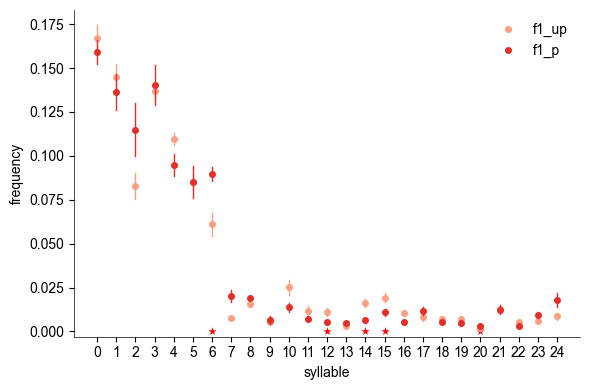

In [ ]:
# specify the two groups for pairwise comparison and plot relative frequencies of syllables, marking significant syllables with a red star
# right over the x axis

current_stats_df = stats_df[(stats_df['group'] == group_1) | (stats_df['group'] == group_2)]

ordering, _ = sort_syllables_by_stat(stats_df, stat=stat)

if (group_1, group_2) in sig_pairs.keys():
    sig_sylls = sig_pairs.get((group_1, group_2))
else:
    sig_sylls = sig_pairs.get((group_2, group_1))

hue = 'group'

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sns.pointplot(
    data=current_stats_df,
    x="syllable",
    y=stat,
    hue=hue,
    palette='Reds',
    linestyle="none",
    errorbar=('se'),
    markersize=3,
    marker="o",
    err_kws={'linewidth':1}
)
syllables = stats_df["syllable"].unique()
markings = []
for s in sig_sylls:
    if s in ordering:
        markings.append(np.where(ordering == s)[0])
    else:
        continue
if len(markings) > 0:
    markings = np.concatenate(markings)
    plt.scatter(markings, [0] * len(markings), color="r", marker="*",linewidths=0.05)
else:
    print("No significant syllables found.")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.5)
ax.spines["bottom"].set_linewidth(0.5)
ax.legend(frameon=False, loc='upper right')
ax.set_ylim([-0.003,None])

plt.tight_layout()

# save fig as png and eps in figs directory
fig.savefig(project_dir+model_name+'/'+fig_dir+'p_'+group_1+'_'+group_2+'_syllable_freq.png')
fig.savefig(project_dir+model_name+'/'+fig_dir+'p_'+group_1+'_'+group_2+'_syllable_freq.eps', format='eps')


In [ ]:
# plot correlation graphs for a phenotype of interest, here avoidance index (ai)
# ai data was saved in an xlsx file with the columns 'file' (subject) and 'ai'

for s in range(len(stats_df["syllable"].unique())):
    current_syllable = s
    current_stats_df = stats_df[(stats_df['syllable'] == current_syllable)]
    correlation_df = pd.DataFrame(columns=['group','frequency','ai'])
    # insert name of excel file with phenotype data (2 columns, indicate column names in usecols=[])
    ai_df = pd.read_excel('',usecols=['file','ai'])
    for i in range(current_stats_df.shape[0]):
        new_entry_df = pd.DataFrame(columns=['group','frequency','ai'],index=range(1))
        group = current_stats_df.iloc[i,0]
        name = current_stats_df.iloc[i,1]
        frequency = current_stats_df.iloc[i,15]
        # find ai for current subject in ai_df
        for j in range(ai_df.shape[0]):
            if name == ai_df.iloc[j,0]:
                ai = ai_df.iloc[j,1]
        new_entry_df.iloc[0,0] = group
        new_entry_df.iloc[0,1] = float(frequency)
        new_entry_df.iloc[0,2] = float(ai)
        correlation_df = pd.concat([correlation_df,new_entry_df])

    correlation_df = correlation_df.astype({'frequency':'float','ai':'float'})

    color = sns.color_palette(palette='BuPu')[5]

    # creates correlation plots colored by group
    lm = sns.lmplot(data=correlation_df,x='frequency',y='ai',col="group",facet_kws=dict(sharex=False, sharey=False),scatter_kws={"color":color}, line_kws={"color":color})
    font={'fontname':'Arial'}
    for group, ax in lm.axes_dict.items():
        r, p = stats.pearsonr(correlation_df[correlation_df['group'] == group]['frequency'],correlation_df[correlation_df['group'] == group]['ai'])
        r2=r**2
        ax.text(0.05,1,'$r^2$={:.2f}, p={:.2g}'.format(r2,p),horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.set_ylim([-1,1])
    plt.suptitle('syllable '+str(current_syllable),fontsize=20,y=1.05)
    
    lm.savefig(project_dir+model_name+'/'+fig_dir+'syllable '+str(current_syllable)+'_corr_by_group.png')

    for group, ax in lm.axes_dict.items():
        plt.clf()
    plt.close()

    # creates correlation plots of all combined data
    rplot = sns.regplot(data=correlation_df,x='frequency',y='ai',scatter_kws={"color":color}, line_kws={"color":color})
    ax = rplot.axes
    r, p = stats.pearsonr(correlation_df['frequency'],correlation_df['ai'])
    r2=r**2
    ax.text(0.05,1,'$r^2$={:.2f}, p={:.2g}'.format(r2,p),horizontalalignment='left',verticalalignment='top',transform=ax.transAxes)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.5)
    ax.spines["bottom"].set_linewidth(0.5)
    ax.set_ylim([-1,1])
    plt.title('syllable '+str(current_syllable),fontsize=16,y=1.05)
    plt.tight_layout()
    figure = rplot.get_figure()
    figure.savefig(project_dir+model_name+'/'+fig_dir+'syllable '+str(current_syllable)+'_corr_combined.png')
    plt.clf()
    plt.close()

In [463]:
sns.color_palette(palette='BuPu')

[(0.861683967704729, 0.91280276816609, 0.9497577854671281),
 (0.7114648212226067, 0.801276432141484, 0.8883044982698962),
 (0.5899884659746252, 0.6747251057285659, 0.8219915417147251),
 (0.5490196078431373, 0.49036524413687044, 0.7286735870818916),
 (0.5378854286812764, 0.3026989619377163, 0.6384467512495194),
 (0.509434832756632, 0.08419838523644751, 0.5030219146482122)]

In [ ]:
# format of moseq_df
moseq_df

,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset
0,325_trimmed_processed.analysis,377.973732,172.962582,0.984688,0.000000,0.000000,4,0,f0_up,True
1,325_trimmed_processed.analysis,377.278987,172.501671,0.983907,0.005023,25.011981,4,1,f0_up,False
2,325_trimmed_processed.analysis,377.042663,172.381574,0.984688,0.010833,7.952668,4,2,f0_up,False
3,325_trimmed_processed.analysis,376.859518,172.851004,0.984688,0.018068,15.116729,4,3,f0_up,False
4,325_trimmed_processed.analysis,377.148449,171.861804,0.984688,0.026973,30.915979,4,4,f0_up,False
...,...,...,...,...,...,...,...,...,...,...
1782800,processed_468.analysis,418.369476,95.253926,-3.006786,0.645790,117.032049,3,17999,f1_up,False
1782801,processed_468.analysis,414.631627,95.003569,-3.006786,0.490013,112.386709,3,18000,f1_up,False
1782802,processed_468.analysis,410.768002,94.074379,-2.993261,0.342506,119.213648,3,18001,f1_up,False
1782803,processed_468.analysis,407.138017,93.298691,-2.981600,0.212598,111.358139,3,18002,f1_up,False


In [ ]:
# for analysis with respect to the subject's position in the video, can create a csv indicating boundaries
# here, x positions are defined for each video to determine whether the mouse is in the left chamber or right chamber
# if arena does not move between videos, can be manually entered
# here, since arena moves between videos, x cutoffs are defined for each video/subject

# read in left and right x cutoff values for each video
l_r_df = pd.read_csv('/Users/claraliff/Desktop/Lab/eLife_paper/kpMoSeq/v3/v3_f0_f1_moseq/2024_11_18-12_14_41/l_r_xcutoffs.csv')
# define whether left or right is conditioned odor side using an experiment metadata excel sheet
c_o_side = pd.read_excel('/Users/claraliff/Desktop/Lab/eLife_paper/kpMoSeq/v3/v3_f0_f1_csvs_grouped.xlsx',usecols="A,D")
port_x_df = pd.DataFrame(columns=['name','port_x'],index=range(99))
port_x_df.loc[:,'name'] = c_o_side['file']
port_x_df

# in our videos, the conditioned odor port, a region of interest in our videos, was always located 200 pixels to the left of the left
# chamber entrance or 200 pixels to the right of the right chamber entrance
# port_x_df defines the x position of the conditioned odor port for each video/subject, to later be used to calculate real-time distance of
# the mouse from the odor source

for x in range(l_r_df.shape[0]):
    if c_o_side.iloc[x,1] == "R":
        port_x = l_r_df.iloc[x,2] + 200
    elif c_o_side.iloc[x,1] == "L":
        port_x = l_r_df.iloc[x,1] - 200
    port_x_df.iloc[x,1] = port_x

port_x_df

,name,port_x
0,325_trimmed_processed.analysis,649
1,326_trimmed_processed.analysis,649
2,327_trimmed_processed.analysis,649
3,328_trimmed_processed.analysis,72
4,329_trimmed_processed.analysis,72
...,...,...
94,processed_464.analysis,74
95,processed_465.analysis,73
96,processed_466.analysis,74
97,processed_467.analysis,76


In [ ]:
# append two columns to moseq_df: the x position of the conditioned odor port, and the x distance of the mouse from the odor port

moseq_df_dist = moseq_df.copy()
moseq_df_dist["port_x"] = np.nan
moseq_df_dist["port_dist"] = np.nan
moseq_df_dist

,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset,port_x,port_dist
0,325_trimmed_processed.analysis,377.973732,172.962582,0.984688,0.000000,0.000000,4,0,f0_up,True,NaN,NaN
1,325_trimmed_processed.analysis,377.278987,172.501671,0.983907,0.005023,25.011981,4,1,f0_up,False,NaN,NaN
2,325_trimmed_processed.analysis,377.042663,172.381574,0.984688,0.010833,7.952668,4,2,f0_up,False,NaN,NaN
3,325_trimmed_processed.analysis,376.859518,172.851004,0.984688,0.018068,15.116729,4,3,f0_up,False,NaN,NaN
4,325_trimmed_processed.analysis,377.148449,171.861804,0.984688,0.026973,30.915979,4,4,f0_up,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1782800,processed_468.analysis,418.369476,95.253926,-3.006786,0.645790,117.032049,3,17999,f1_up,False,NaN,NaN
1782801,processed_468.analysis,414.631627,95.003569,-3.006786,0.490013,112.386709,3,18000,f1_up,False,NaN,NaN
1782802,processed_468.analysis,410.768002,94.074379,-2.993261,0.342506,119.213648,3,18001,f1_up,False,NaN,NaN
1782803,processed_468.analysis,407.138017,93.298691,-2.981600,0.212598,111.358139,3,18002,f1_up,False,NaN,NaN


In [ ]:
# for each row (frame) of all videos, calculate the x distance of the mouse x centroid from the x coordinate of the conditioned odor port

for x in range(moseq_df_dist.shape[0]):
    current_name = moseq_df_dist.iloc[x,0]
    i = port_x_df.index[port_x_df.iloc[:,0].str.contains(current_name)]
    port_x = port_x_df.iloc[i,1]
    moseq_df_dist.iloc[x,10] = port_x
    current_centroid_x = moseq_df_dist.iloc[x,1]
    port_dist = abs(port_x - current_centroid_x)
    moseq_df_dist.iloc[x,11] = port_dist
moseq_df_dist

In [ ]:
# sanity check that all distances are positive
moseq_df_dist[moseq_df_dist['port_dist']<0]

,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset,port_x,port_dist


In [ ]:
# save moseq_df with distance info
moseq_df_dist.to_csv(project_dir+model_name+'/moseq_df/moseq_df_dist.csv')

In [ ]:
# read in moseq_df_dist if continuing after checkpoint
# moseq_df_dist = pd.read_csv(project_dir+model_name+'/moseq_df/moseq_df_dist.csv')

In [ ]:
# create temp_df, a subset of moseq_df_dist with your two groups for comparison
# filtering to only analyze top 20 (20 most frequent) syllables

temp_df = moseq_df_dist[(moseq_df_dist['group'] == 'f1_up') | (moseq_df_dist['group'] == 'f1_p')]
temp_df = temp_df[temp_df['syllable'] < 20]
temp_df

,Unnamed: 0,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset,port_x,port_dist
539997,539997,processed_395.analysis,314.466866,82.465819,-0.840731,0.000000,0.000000,2,0,f1_up,True,69.0,245.466866
539998,539998,processed_395.analysis,312.461881,82.790523,-0.812531,0.060667,60.933216,2,1,f1_up,False,69.0,243.461881
539999,539999,processed_395.analysis,312.191837,82.994746,-0.812531,0.110261,10.157175,2,2,f1_up,False,69.0,243.191837
540000,540000,processed_395.analysis,312.050460,82.915487,-0.812531,0.141494,4.862358,2,3,f1_up,False,69.0,243.050460
540001,540001,processed_395.analysis,312.206913,82.521490,-0.788361,0.153129,12.717707,2,4,f1_up,False,69.0,243.206913
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1782800,1782800,processed_468.analysis,418.369476,95.253926,-3.006786,0.645790,117.032049,3,17999,f1_up,False,613.0,194.630524
1782801,1782801,processed_468.analysis,414.631627,95.003569,-3.006786,0.490013,112.386709,3,18000,f1_up,False,613.0,198.368373
1782802,1782802,processed_468.analysis,410.768002,94.074379,-2.993261,0.342506,119.213648,3,18001,f1_up,False,613.0,202.231998
1782803,1782803,processed_468.analysis,407.138017,93.298691,-2.981600,0.212598,111.358139,3,18002,f1_up,False,613.0,205.861983


In [ ]:
# create variables for x position (all frames, all subjects) for each group
f1_p_x_dist = temp_df[temp_df['group'] == 'f1_p']
f1_p_x_dist = f1_p_x_dist.iloc[:,2]
f1_p_x_dist

f1_up_x_dist = temp_df[temp_df['group'] == 'f1_up']
f1_up_x_dist = f1_up_x_dist.iloc[:,2]
f1_up_x_dist

539997     314.466866
539998     312.461881
539999     312.191837
540000     312.050460
540001     312.206913
              ...    
1782800    418.369476
1782801    414.631627
1782802    410.768002
1782803    407.138017
1782804    404.965309
Name: centroid_x, Length: 556323, dtype: float64

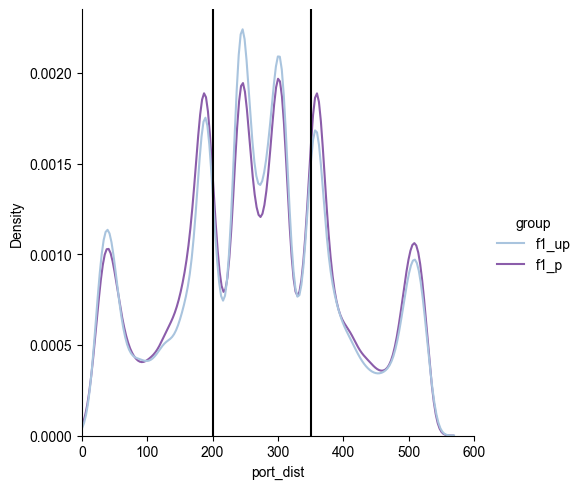

In [ ]:
# plot kde for x position by group
# black bars indicate the left/right chamber entries (cutoffs)

d = sns.displot(temp_df,x='port_dist',palette='BuPu',hue='group',kind="kde",common_norm=True)
d.set(xlim=(0,600))
plt.axvline(200,0,1,color='black')
plt.axvline(350,0,1,color='black')
d.savefig(project_dir+model_name+'/'+fig_dir+'port_dist_hist_kde_common_norm.eps', format='eps')

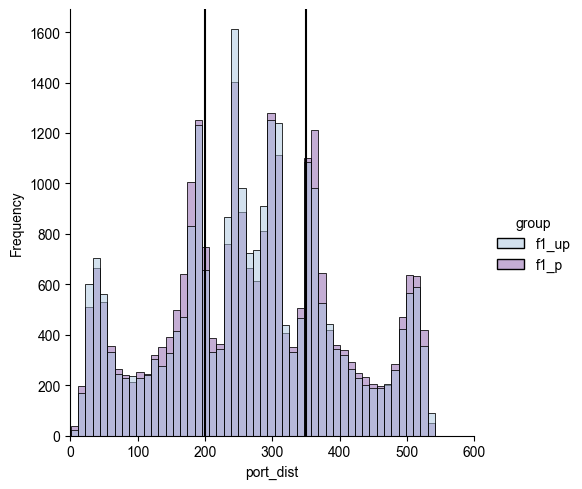

In [ ]:
# plot as histogram

d = sns.displot(temp_df,x='port_dist',palette='BuPu',hue='group',kind="hist",stat='frequency',bins=50)
d.set(xlim=(0,600))
plt.axvline(200,0,1,color='black')
plt.axvline(350,0,1,color='black')
# d.savefig(project_dir+model_name+'/'+fig_dir+'port_dist_hist_freq_bins25.eps', format='eps')
# d.savefig(project_dir+model_name+'/'+fig_dir+'port_dist_hist_freq_bins25.png', format='png')

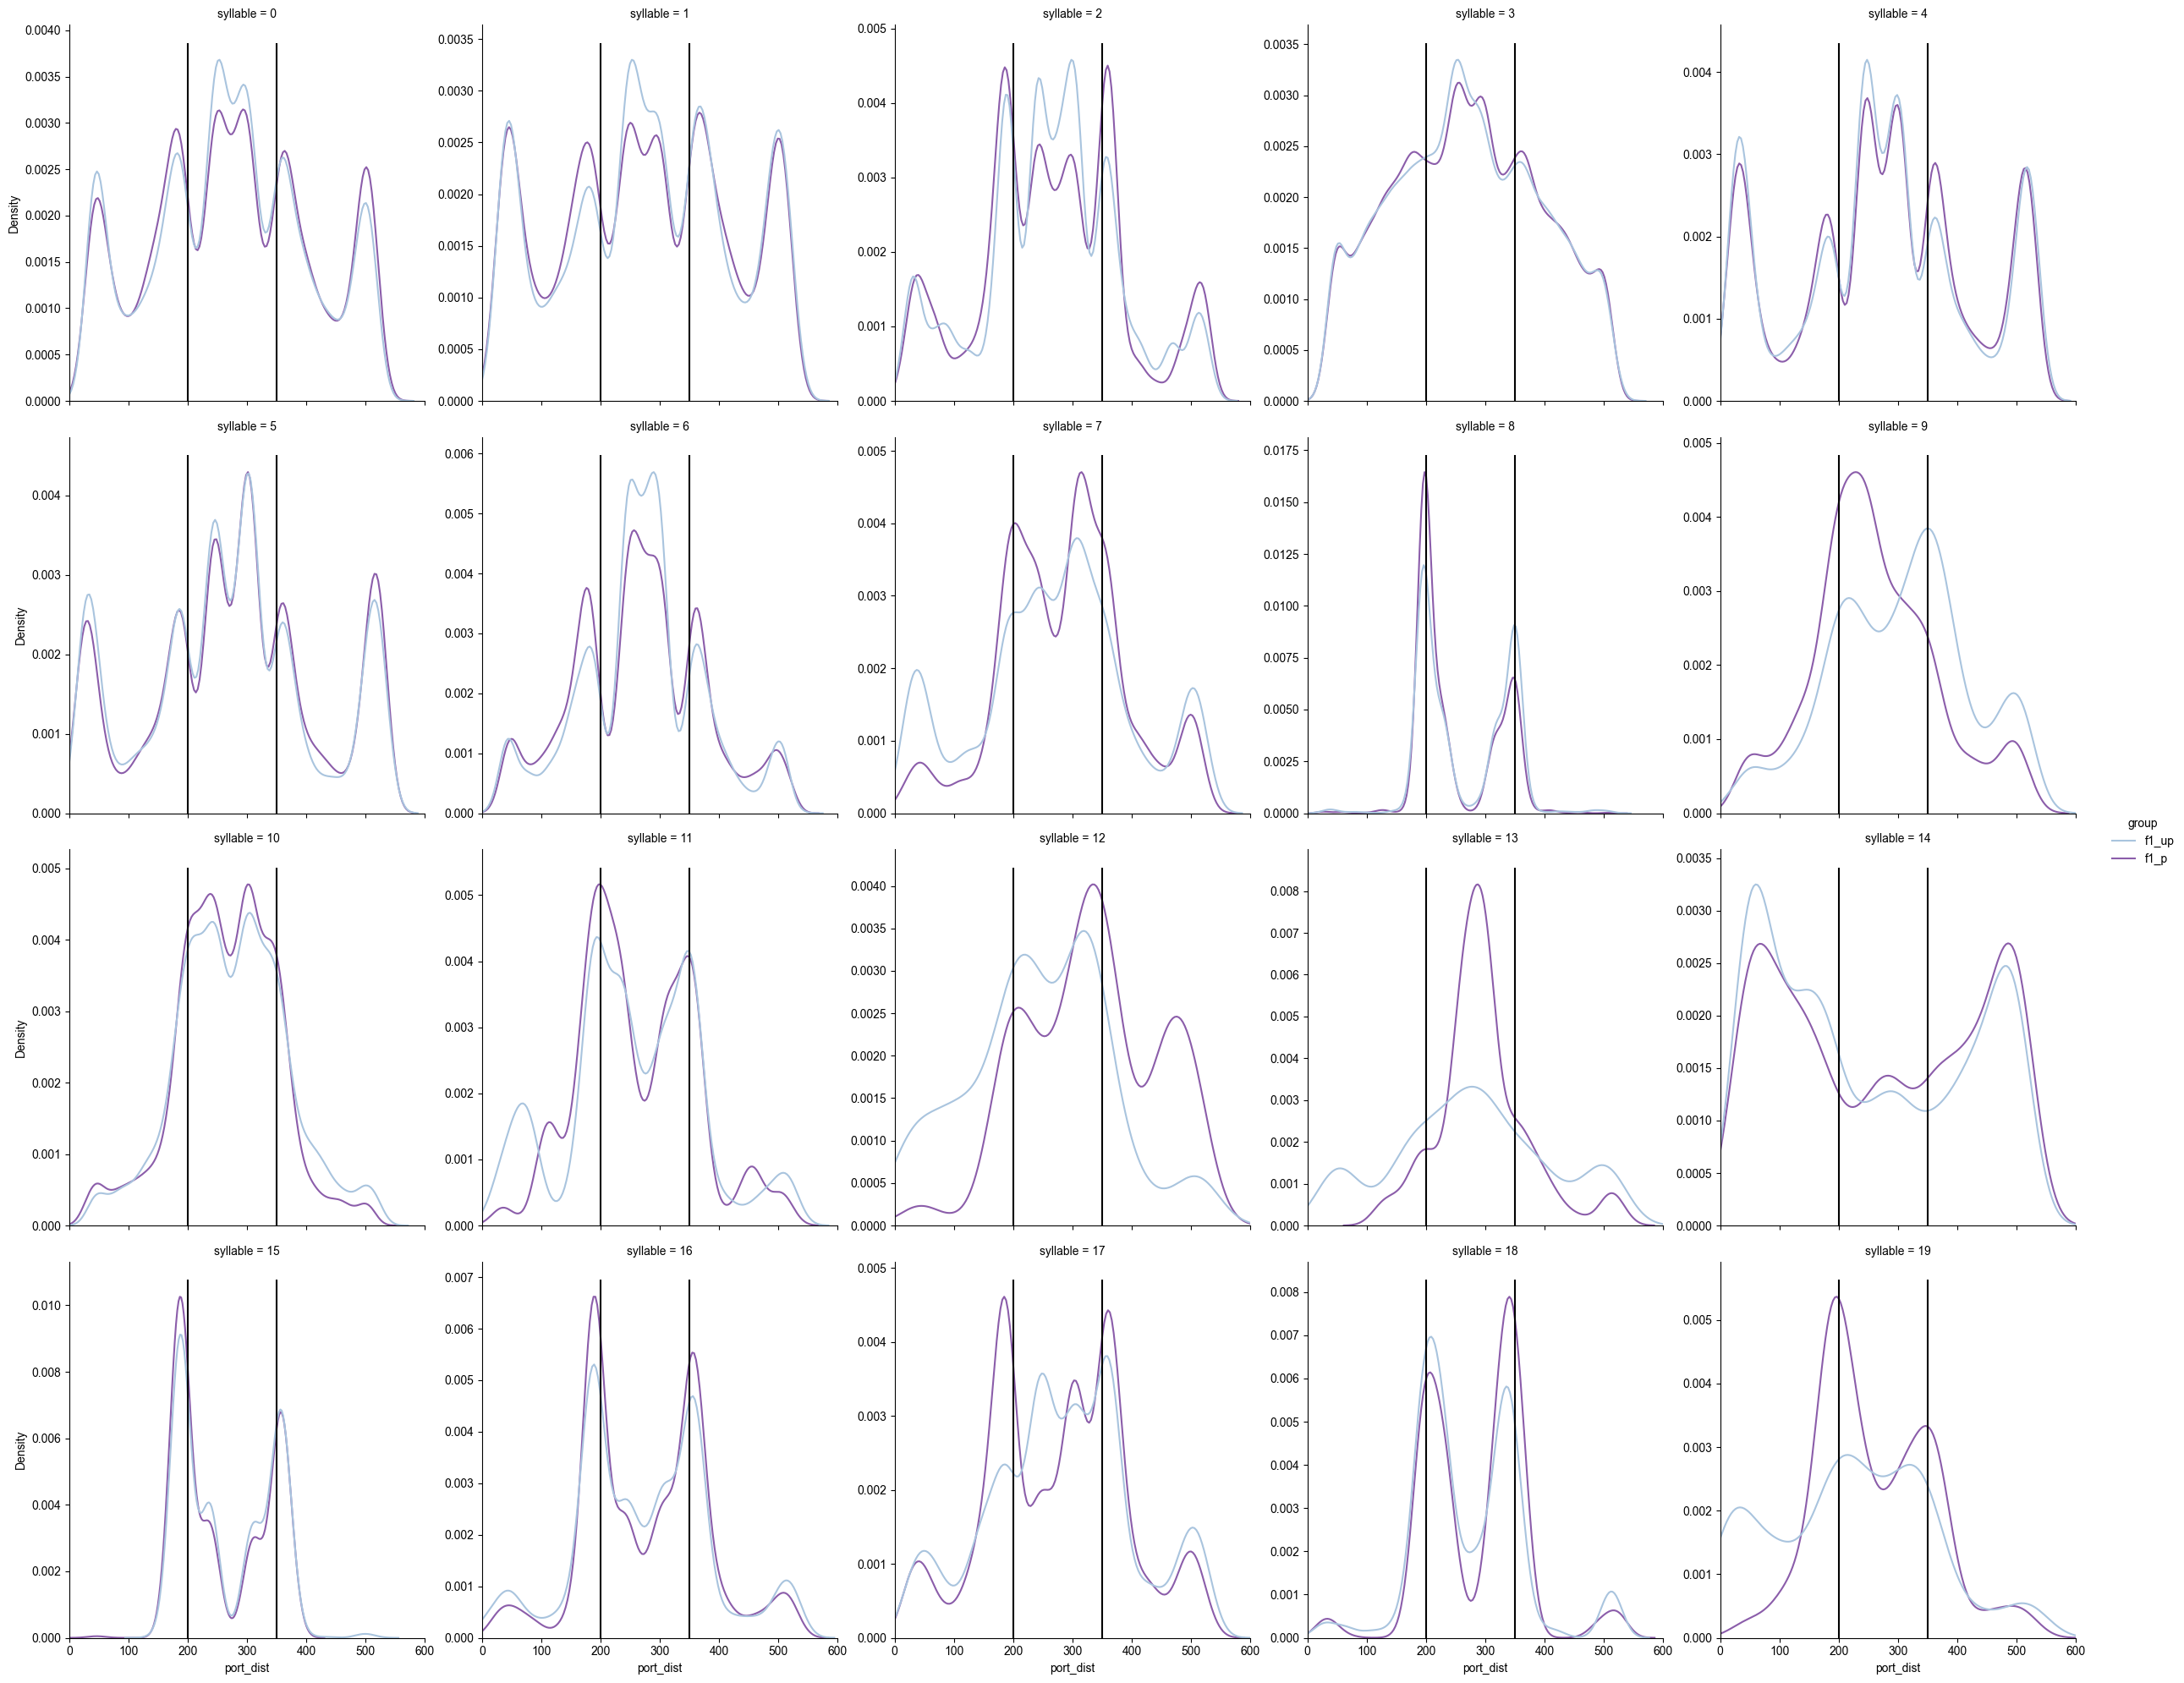

In [ ]:
# plot syllable usage across relative x position for each syllable
dp = sns.displot(temp_df,x='port_dist',palette='BuPu',col='syllable',hue='group',col_wrap=5,facet_kws={'sharey':False},kind='kde',common_norm=False)
for ax in dp.axes.flat:
    ymin,ymax=ax.get_ylim()
    ax.set(xlim=(0,600))
    ax.vlines(200,ymin,ymax,colors='black')
    ax.vlines(350,ymin,ymax,colors='black')
dp.savefig(project_dir+model_name+'/'+fig_dir+'port_dist_hist_by_syll.eps', format='eps')
